# Opinion Detection - Unsupervised

In [1]:
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
import text_normalizer as tn
import nltk
nltk.download('movie_reviews')
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jerez\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\jerez\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jerez\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\jerez\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


### <font color='orange'>Load and Preprocess Data</font>

In [2]:
from nltk.corpus import movie_reviews as mr
from random import shuffle, seed
seed(42)

documents = [(mr.raw(file_id), 1 if category == 'pos' else 0) for category in mr.categories() for file_id in mr.fileids(category)]
shuffle(documents)

In [3]:
df_train, df_test = documents[:1600], documents[1600:]

X_train = [item[0] for item in df_train]
y_train = [item[1] for item in df_train]

X_test = [item[0] for item in df_test]
y_test = [item[1] for item in df_test]

X_train_cleaned = tn.normalize_corpus(X_train, split_phrases = True, stopword_removal = False)
X_test_cleaned = tn.normalize_corpus(X_test, split_phrases = True, stopword_removal = False)

### <font color='orange'>Baseline Model</font>

In [8]:
#TextServer
from textserver import TextServer
ts = TextServer('alberto.jerez6', 'aYe21B5r!', 'senses')

default_coef = {tag: 1 for tag in ['n', 'v', 'r', 'a', 's']} #s -> satellite adjectives  "arid" = "dry" + a particular context (i.e. climates)
def sentiwn_baseline_TxtSvr(corpora, coef = default_coef):

    pred = list()
    for i, review in enumerate(corpora):
        final_score = token_count = 0
        annotated_phrase = ts.senses(review)
        syn_codes = [word[4] for word in annotated_phrase[0] if word[4] != 'N/A']
        for code in syn_codes:
            synset = wn.synset_from_pos_and_offset(code[9], int(code[:8]))
            if synset:
                    sentiSynset = swn.senti_synset(synset.name())
                    final_score += coef[synset.pos()]*(sentiSynset.pos_score() - sentiSynset.neg_score())
                    token_count += 1
        norm_final_score = round(float(final_score) / token_count, 3)
        final_sentiment = 1 if norm_final_score >= 0 else 0
        pred.append(final_sentiment)
    return pred                 

In [12]:
from nltk.wsd import lesk
from nltk.tokenize import word_tokenize

stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no') ; stopword_list.remove('not')

default_coef = {tag: 1 for tag in ['n', 'v', 'r', 'a', 's']} #s -> satellite adjectives  "arid" = "dry" + a particular context (i.e. climates)
def sentiwn_baseline_lesk(corpora, coef = default_coef):

    pred = list()
    for review in corpora:
        final_score = token_count = 0
        phrases = review.split('linebreak')
        for phrase in phrases:
            for word in phrase.split():
                if word not in stopword_list:
                    synset = lesk(word_tokenize(phrase), word)
                    if synset:
                        sentiSynset = swn.senti_synset(synset.name())
                        final_score += coef[synset.pos()]*(sentiSynset.pos_score() - sentiSynset.neg_score())
                        token_count += 1

        norm_final_score = round(float(final_score) / token_count, 3)
        final_sentiment = 1 if norm_final_score >= 0 else 0
        pred.append(final_sentiment)
    return pred

### <font color='orange'>Predict Sentiment for Test Reviews</font>

In [16]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


def model_performance(true_labels, predicted_labels,classes):    
        conf_matrix = confusion_matrix(true_labels, predicted_labels)
        df_cm = pd.DataFrame(conf_matrix, index = classes, columns = classes)

        print('Accuracy:  {:2.2%} '.format(accuracy_score(true_labels, predicted_labels)))
        print('Precision: {:2.2%} '.format(precision_score(true_labels, predicted_labels, average = 'weighted')))
        print('Recall:    {:2.2%} '.format(recall_score(true_labels, predicted_labels, average = 'weighted')))
        print('F1 Score:  {:2.2%} '.format(f1_score(true_labels, predicted_labels, average = 'weighted')))   
        print("\n")
        print("Classification Report: \n",)
        print( classification_report(true_labels, predicted_labels))
        plt.figure(figsize=(5,5))
        sn.heatmap(df_cm, annot = True, fmt = ".3f", linewidths = .5, square = True)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        print("\nConfusion matrix:")
        score = accuracy_score(true_labels, predicted_labels)
        all_sample_title = 'Accuracy Score: {0}%'.format(np.round(score,4)*100)
        plt.title(all_sample_title, size = 12)


Accuracy:  65.50% 
Precision: 66.53% 
Recall:    65.50% 
F1 Score:  64.86% 


Classification Report: 

              precision    recall  f1-score   support

           0       0.71      0.52      0.60       198
           1       0.63      0.79      0.70       202

    accuracy                           0.66       400
   macro avg       0.67      0.65      0.65       400
weighted avg       0.67      0.66      0.65       400


Confusion matrix:


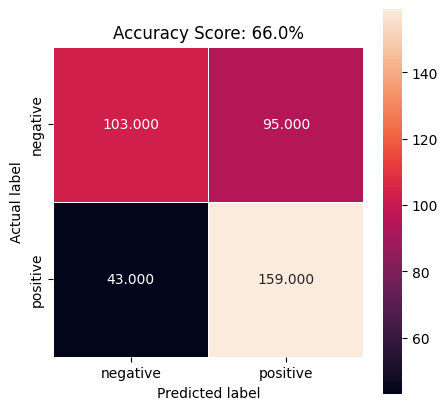

In [15]:
#Text server
y_pred = list()
for i in range(4):
    y_pred.extend(sentiwn_baseline_TxtSvr(X_test_cleaned[i*100:(i+1)*100]))

model_performance(true_labels = y_test, predicted_labels = y_pred, 
                                  classes=['negative', 'positive'])

Accuracy:  68.00% 
Precision: 68.30% 
Recall:    68.00% 
F1 Score:  67.90% 


Classification Report: 

              precision    recall  f1-score   support

           0       0.66      0.74      0.70       198
           1       0.71      0.62      0.66       202

    accuracy                           0.68       400
   macro avg       0.68      0.68      0.68       400
weighted avg       0.68      0.68      0.68       400


Confusion matrix:


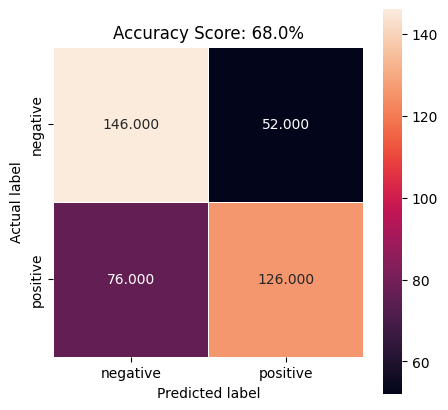

In [35]:
#Lesk
y_pred = sentiwn_baseline_lesk(X_test_cleaned)
model_performance(true_labels = y_test, predicted_labels = y_pred, 
                                  classes=['negative', 'positive'])

### <font color='orange'>Train POS Scores' Ponderations</font>

In [54]:
class train_coef:
    def __init__(self, JJ_coef = 1, RB_coef = 1, NN_coef = 1, VB_coef = 1):
        self._coef = {'n': NN_coef, 'v': VB_coef, 'r' : RB_coef, 'a': JJ_coef, 's': JJ_coef}

    def predict(self, X):
        pred = sentiwn_baseline_lesk(X, self._coef)
        return pred

In [55]:
from sklearn.metrics import accuracy_score
params = ['JJ_coef', 'RB_coef', 'NN_coef', 'VB_coef']
coefs = {tag: 1 for tag in params}

coefficients = [0.2, 0.4, 0.6, 0.8, 1]; acc = 0
for tag in params:
    for coef in coefficients:
        act_coefs = coefs.copy()
        act_coefs[tag] = coef

        model = train_coef(**act_coefs)
        y_pred = model.predict(X_train_cleaned)
        act_acc = accuracy_score(y_train, y_pred)
        if act_acc > acc:
            coefs = act_coefs
            acc = act_acc

print("Optimized coefficients:", coefs)

Optimized coefficients: {'JJ_coef': 1, 'RB_coef': 0.8, 'NN_coef': 1, 'VB_coef': 0.6}


In [59]:
coefficients = [1, 1.25, 1.5]; acc = 0
params = ['JJ_coef', 'NN_coef']
for tag in params:
    for coef in coefficients:
        act_coefs = coefs.copy()
        act_coefs[tag] = coef

        model = train_coef(**act_coefs)
        y_pred = model.predict(X_train_cleaned)
        act_acc = accuracy_score(y_train, y_pred)
        if act_acc > acc:
            coefs = act_coefs
            acc = act_acc

print("Optimized coefficients:", coefs)

Optimized coefficients: {'JJ_coef': 1.5, 'RB_coef': 0.8, 'NN_coef': 1, 'VB_coef': 0.6}


In [70]:
coefficients = [2, 2.5, 3]; acc = 0
params = ['JJ_coef']
for tag in params:
    for coef in coefficients:
        act_coefs = coefs.copy()
        act_coefs[tag] = coef

        model = train_coef(**act_coefs)
        y_pred = model.predict(X_train_cleaned)
        act_acc = accuracy_score(y_train, y_pred)
        if act_acc > acc:
            coefs = act_coefs
            acc = act_acc

print("Optimized coefficients:", coefs)

Optimized coefficients: {'JJ_coef': 2, 'RB_coef': 0.8, 'NN_coef': 1, 'VB_coef': 0.6}


Accuracy:  68.75% 
Precision: 68.82% 
Recall:    68.75% 
F1 Score:  68.73% 


Classification Report: 

              precision    recall  f1-score   support

           0       0.67      0.71      0.69       198
           1       0.70      0.66      0.68       202

    accuracy                           0.69       400
   macro avg       0.69      0.69      0.69       400
weighted avg       0.69      0.69      0.69       400


Confusion matrix:


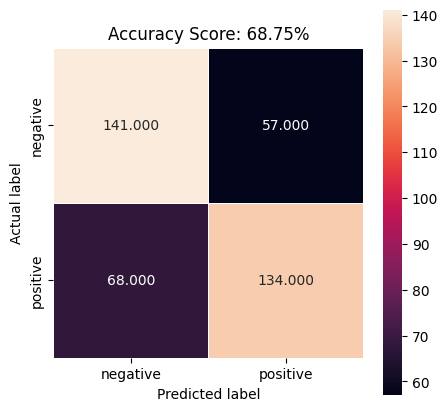

In [21]:
optimized_coef = {'n': 1, 'v': 0.6, 'r': 0.8, 'a': 2, 's': 2}
y_pred = sentiwn_baseline_lesk(X_test_cleaned, optimized_coef)
model_performance(true_labels = y_test, predicted_labels = y_pred, 
                                  classes=['negative', 'positive'])

### <font color='orange'>Negation Handling</font>

In [10]:
def Negation(sentence):	
    '''
    Input: String representing a sentence
    Output: Tokenized sentence with negation handled (List of words)
    '''
    temp = int(0)
    tokens = nltk.word_tokenize(sentence)
    tokens = [token.strip() for token in tokens]
    for i in range(len(tokens)):  
      if tokens[i-1] in ['not', 'no']:
        antonyms = []
        syn = lesk(word_tokenize(sentence), tokens[i], pos = 'a')
        if syn:
           w1 = syn.name()
        else:
           continue
        temp = 0
        for l in syn.lemmas():
            if l.antonyms():
                antonyms.append(l.antonyms()[0].name())
                max_dissimilarity = 0
                for ant in antonyms:
                    syns = wn.synsets(ant)
                    w2 = syns[0].name()
                    syns = wn.synsets(tokens[i])
                    w1 = syns[0].name()
                    word1 = wn.synset(w1)
                    word2 = wn.synset(w2)
                    if isinstance(word1.wup_similarity(word2), float) or isinstance(word1.wup_similarity(word2), int):
                        temp = 1 - word1.wup_similarity(word2)
                    if temp>max_dissimilarity:
                        max_dissimilarity = temp
                        antonym_max = ant
                        tokens[i] = antonym_max
                        tokens[i-1] = ''
    while '' in tokens:
      tokens.remove('')
    return tokens

In [13]:
#Negation Handler Use example
s = 'I am not happy with you!'
Negation(s)

['I', 'am', 'unhappy', 'with', 'you', '!']

In [26]:
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no') ; stopword_list.remove('not')

def sentiwn_negation(corpora):

    coef = {'n': 1, 'v': 0.6, 'r': 0.8, 'a': 2, 's': 2}
    pred = list()
    for review in corpora:
        final_score = token_count = 0
        phrases = review.split('linebreak')
        for phrase in phrases:
            words = Negation(phrase)
            for word in words:
                if word not in stopword_list:
                    synset = lesk(word_tokenize(phrase), word)
                    if synset:
                        sentiSynset = swn.senti_synset(synset.name())
                        final_score += coef[synset.pos()]*(sentiSynset.pos_score() - sentiSynset.neg_score())
                        token_count += 1

        norm_final_score = round(float(final_score) / token_count, 3)
        final_sentiment = 1 if norm_final_score >= 0 else 0
        pred.append(final_sentiment)
    return pred

Accuracy:  69.00% 
Precision: 69.29% 
Recall:    69.00% 
F1 Score:  68.85% 


Classification Report: 

              precision    recall  f1-score   support

           0       0.72      0.62      0.66       198
           1       0.67      0.76      0.71       202

    accuracy                           0.69       400
   macro avg       0.69      0.69      0.69       400
weighted avg       0.69      0.69      0.69       400


Confusion matrix:


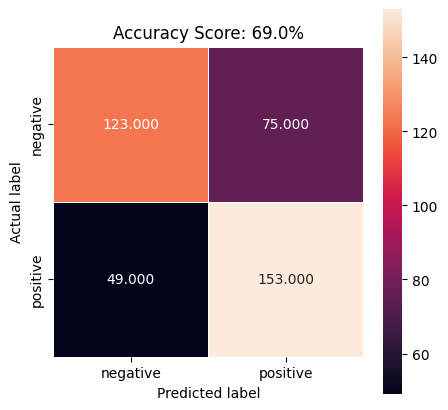

In [27]:
y_pred = sentiwn_negation(X_test_cleaned)
model_performance(true_labels = y_test, predicted_labels = y_pred, 
                                  classes=['negative', 'positive'])

### <font color='orange'>Exclamation Mark Handling</font>

In [39]:
import re
exclamation_marks = re.findall('!', " ".join(X_test_cleaned))

print("Number of exclamation marks found:", len(exclamation_marks))

Number of exclamation marks found: 192


In [72]:
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no') ; stopword_list.remove('not')

def sentiwn_def(corpora):

    coef = {'n': 1, 'v': 0.6, 'r': 0.8, 'a': 2, 's': 2}
    pred = list()
    for review in corpora:
        final_score = token_count = 0
        phrases = review.split('linebreak')
        for phrase in phrases:
            phrase_score = 0
            words = Negation(phrase)
            for word in words:

                if word == '!':
                    phrase_score *= 2

                elif word not in stopword_list:
                    synset = lesk(word_tokenize(phrase), word)
                    if synset:
                        sentiSynset = swn.senti_synset(synset.name())
                        phrase_score += coef[synset.pos()]*(sentiSynset.pos_score() - 0.92*sentiSynset.neg_score())
                        token_count += 1
                
            final_score += phrase_score
        norm_final_score = round(float(final_score) / token_count, 3)
        final_sentiment = 1 if norm_final_score >= 0 else 0
        pred.append(final_sentiment)
    return pred

Accuracy:  69.00% 
Precision: 69.20% 
Recall:    69.00% 
F1 Score:  68.89% 


Classification Report: 

              precision    recall  f1-score   support

           0       0.71      0.63      0.67       198
           1       0.67      0.75      0.71       202

    accuracy                           0.69       400
   macro avg       0.69      0.69      0.69       400
weighted avg       0.69      0.69      0.69       400


Confusion matrix:


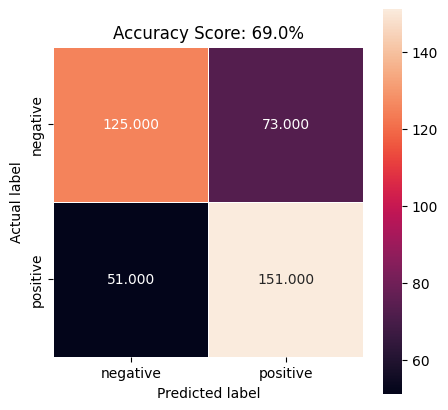

In [73]:
y_pred = sentiwn_def(X_test_cleaned)
model_performance(true_labels = y_test, predicted_labels = y_pred, 
                                  classes=['negative', 'positive'])